# CAPSTON PROJECT

---



## STEP 1: LOAD and IMPORT LIBRARIES

---



In [1]:
import os
import re
import string
import psycopg2
import getpass
import pandas as pd
import numpy as np

## STEP 2: IMPORT DATA

---



In [2]:
# Request user for password to access database
db_password = getpass.getpass(prompt='DB Password ')

# Create SQL engine with connection parameters to connect to AWS RDS Postgres instance
engine = psycopg2.connect(
    database="Capstone_Project_Group_9",
    user="postgres",
    password=db_password,
    host="capstone-project-group-9.c4857qrbkptn.us-east-2.rds.amazonaws.com",
    port='5432'
)

# Show sample of the imported data
dataset_df = pd.read_sql('SELECT * FROM fake_job_postings', engine)
dataset_df.head(1)

DB Password ········


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,US; NY; New York,Marketing,None,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0


In [3]:
# Drop columns with too many null values or where all values are unique
dataset_df = dataset_df.drop(columns=['job_id','salary_range','title'])

In [4]:
# Display number of null values for each column
dataset_df.isnull().sum()

location                 346
department             11547
company_profile         3308
description                0
requirements            2694
benefits                7206
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
# Split the location columns by the seperator and only keep the country
# Only country is kept due to misspelled states and cities and some rows have multiple states and cities
# that do not have a seperator
dataset_df['Country'] = dataset_df['location'].str.split(';').str[0]
dataset_df = dataset_df.drop(columns=['location'])
dataset_df.head(1)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0,US


In [6]:
# Replace null values with "not specified" string
dataset_df = dataset_df.fillna('not specified')
dataset_df.head(1)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,not specified,0,1,0,Other,Internship,not specified,not specified,Marketing,0,US


In [7]:
# Define columns that need to be cleaned
clean_cols = ["company_profile", "description", "requirements", "benefits"]
# Loop through clean_cols and remove punctuation and characters
for col in clean_cols:
    dataset_df[col] = dataset_df[col].replace(r'[^a-zA-Z0-9\s]', '',regex=True)
    dataset_df[col] = dataset_df[col].replace(r'\s{2,}', '',regex=True)

dataset_df.head(1)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,Were Food52 and weve created a groundbreaking ...,Food52 a fastgrowing James Beard Awardwinning ...,Experience with content management systems a m...,not specified,0,1,0,Other,Internship,not specified,not specified,Marketing,0,US


In [8]:
# check the number of null values in columns
dataset_df.isnull().sum()

department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Country                0
dtype: int64

In [9]:
# Remove any whitespace from the country, city and state columns
### code is kept for future compatibility ###
#dataset_df['Country'] = dataset_df['Country'].map(lambda x: x.strip())

#dataset_df.head()

In [10]:
# make all text lower case
string_cols = list(dataset_df.select_dtypes(include='object'))
for col in string_cols:
    dataset_df[col] = dataset_df[col].str.lower()

#dataset_df.head()

In [11]:
# Get number of unique values in each column
dataset_df.nunique()

department              1284
company_profile         1710
description            14727
requirements           11911
benefits                6022
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            6
required_experience        8
required_education        14
industry                 132
function                  38
fraudulent                 2
Country                   91
dtype: int64

## Step 3: Feature encoding

---



In [12]:
# Import libraries required for encoding
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

In [13]:
# Define Ordinal and Nominal columns
nom_cols = ['department', 'industry', 'function', 'Country']
ord_cols = ['employment_type','required_experience','required_education']

In [14]:
# Run TargetEncoder on nominal columns
Targetenc = TargetEncoder()
for col in nom_cols:
    values = Targetenc.fit_transform(X = dataset_df[col], y = dataset_df['fraudulent'])
    dataset_df[col] = values[col]

dataset_df.head(2)

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,0.004963,were food52 and weve created a groundbreaking ...,food52 a fastgrowing james beard awardwinning ...,experience with content management systems a m...,not specified,0,1,0,other,internship,not specified,0.056088,0.012048,0,0.068506
1,0.000871,90 seconds the worlds cloud video production s...,organisedfocusedvibrantawesomedo you have a pa...,what we expect from youyour key responsibility...,what you will get from usthrough being part of...,0,1,0,full-time,not applicable,not specified,0.054348,0.054516,0,0.000000


In [15]:
# Run labelEncoder on Ordinal columns
le = LabelEncoder()
for col in ord_cols:
    dataset_df[col] = le.fit_transform(dataset_df[col])

In [16]:
# rename all columns to have data_ prefix for easy feature identification in machine learning model
for col in dataset_df.columns:
    dataset_df.rename(columns = {col:f'data_{col}'}, inplace = True)
    
# update clean_cols to have new column names    
clean_cols = ["data_company_profile", "data_description", "data_requirements", "data_benefits"]

In [17]:
dataset_df.head(1)

,data_department,data_company_profile,data_description,data_requirements,data_benefits,data_telecommuting,data_has_company_logo,data_has_questions,data_employment_type,data_required_experience,data_required_education,data_industry,data_function,data_fraudulent,data_Country
0,0.004963,were food52 and weve created a groundbreaking ...,food52 a fastgrowing james beard awardwinning ...,experience with content management systems a m...,not specified,0,1,0,3,4,6,0.056088,0.012048,0,0.068506


In [18]:
dataset_df.dtypes

data_department             float64
data_company_profile         object
data_description             object
data_requirements            object
data_benefits                object
data_telecommuting            int64
data_has_company_logo         int64
data_has_questions            int64
data_employment_type          int32
data_required_experience      int32
data_required_education       int32
data_industry               float64
data_function               float64
data_fraudulent               int64
data_Country                float64
dtype: object

## Step 4: Tockenizing

---



### NLTK 

In [19]:
# Import libraries for NLTK and sklearn
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khashayar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# create stopwords
stop = stopwords.words('english')

In [21]:
# for each column in clean_cols remove stopwords
for col in clean_cols:
  dataset_df[col] = dataset_df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [22]:
# Run Stemming on clean_cols
porter = PorterStemmer()

for col in clean_cols:
  dataset_df[col] = dataset_df[col].apply(porter.stem)

In [23]:
# Combine all columns in clean_cols into single text column and create new column witi length of text
dataset_df['combined_text'] = dataset_df['data_company_profile'] + dataset_df['data_description'] + dataset_df['data_requirements'] + dataset_df['data_benefits']
dataset_df['combined_text_length'] = dataset_df['combined_text'].str.len()

# Create list of columns for vectorization
num_cols = list(dataset_df.select_dtypes(include=['int64','float64']))
num_cols.append('combined_text')

### View Resulting Output from NLTK

In [24]:
dataset_df.head(2)

,data_department,data_company_profile,data_description,data_requirements,data_benefits,data_telecommuting,data_has_company_logo,data_has_questions,data_employment_type,data_required_experience,data_required_education,data_industry,data_function,data_fraudulent,data_Country,combined_text,combined_text_length
0,0.004963,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management systems major pl...,specifi,0,1,0,3,4,6,0.056088,0.012048,0,0.068506,food52 weve created groundbreaking awardwinnin...,2036
1,0.000871,90 seconds worlds cloud video production servi...,organisedfocusedvibrantawesomedo passion custo...,expect youyour key responsibility communicate ...,get usthrough part 90 seconds team gainexperie...,0,1,0,1,6,6,0.054348,0.054516,0,0.000000,90 seconds worlds cloud video production servi...,4620


In [25]:
# Create dataframe with only required columns for vectorization
vector_df = dataset_df[num_cols]

In [26]:
vector_df.head(1)

,data_department,data_telecommuting,data_has_company_logo,data_has_questions,data_industry,data_function,data_fraudulent,data_Country,combined_text_length,combined_text
0,0.004963,0,1,0,0.056088,0.012048,0,0.068506,2036,food52 weve created groundbreaking awardwinnin...


In [27]:
# Create Term freqeuncy Vectorizer
tfidf_vect = TfidfVectorizer(use_idf=True,
                      smooth_idf=True,
                      min_df = 1,
                      stop_words = 'english',
                      max_features = 1000)

In [28]:
# Run term frequency vectorizor
term_freq_idf_df = pd.DataFrame(tfidf_vect.fit_transform(vector_df['combined_text']).toarray(), columns=tfidf_vect.get_feature_names_out())

In [29]:
term_freq_idf_df.head(2)

,10,100,12,20,200,30,401k,50,90,ability,...,worldwide,write,writing,written,year,years,york,youll,young,youre
0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.269674,0.0,0.0,0.0
1,0.0,0.05194,0.0,0.0,0.0,0.051452,0.0,0.057302,0.255256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Create DF ready for Machine Learning

In [30]:
# Merge vector_df with term frequency vectorizor output
ml_df = vector_df.merge(term_freq_idf_df, left_index=True, right_index=True, how='inner')

In [31]:
# drop the original text column
ml_df.drop('combined_text',axis=1,inplace=True)

In [32]:
ml_df.head(2)

,data_department,data_telecommuting,data_has_company_logo,data_has_questions,data_industry,data_function,data_fraudulent,data_Country,combined_text_length,10,...,worldwide,write,writing,written,year,years,york,youll,young,youre
0,0.004963,0,1,0,0.056088,0.012048,0,0.068506,2036,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.269674,0.0,0.0,0.0
1,0.000871,0,1,0,0.054348,0.054516,0,0.000000,4620,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Step 5: Machine Learning
ml_df is the dataframe ready for machine learning
---

In [33]:
from sklearn.model_selection import train_test_split
x = ml_df.drop('data_fraudulent',axis=1)
y = ml_df.data_fraudulent
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1,stratify=y)

In [34]:
from sklearn.preprocessing import StandardScaler
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
x_scaler = scaler.fit(x_train)

# Scaling the data.
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [35]:
# Checking the mean and STD of our first row, STD must be very close to 1 and mean has to be very close to 0 to be satisfactory
import numpy as np
print(np.mean(x_train_scaled[:,0]))
print(np.std(x_train_scaled[:,0]))

-1.0928369817339348e-16
1.0


In [36]:
import lightgbm as lgb
from sklearn import metrics

In [37]:
model_lightgbm = lgb.LGBMClassifier(num_iteration=250,learning_rate=0.08,max_depth=7,random_state=1,bagging_fraction=0.9)
model_lightgbm.fit(x_train_scaled,y_train,eval_set=[(x_test_scaled,y_test),(x_train_scaled,y_train)],
          verbose=50,eval_metric='logloss')

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_iterations is set=250, num_iteration=250 will be ignored. Current value: num_iterations=250
[50]	training's binary_logloss: 0.0318977	valid_0's binary_logloss: 0.063422
[100]	training's binary_logloss: 0.017363	valid_0's binary_logloss: 0.056718
[150]	training's binary_logloss: 0.0113015	valid_0's binary_logloss: 0.0538649
[200]	training's binary_logloss: 0.00751677	valid_0's binary_logloss: 0.0529806
[250]	training's binary_logloss: 0.00521199	valid_0's binary_logloss: 0.052866


LGBMClassifier(bagging_fraction=0.9, learning_rate=0.08, max_depth=7,
               num_iteration=250, random_state=1)

In [38]:
print('Testing accuracy of the lightgbm model is  {:.4f}'.format(model_lightgbm.score(x_train_scaled,y_train)))

Testing accuracy of the lightgbm model is  0.9997


In [39]:
print('Testing accuracy of the lightgbm model is  {:.4f}'.format(model_lightgbm.score(x_test_scaled,y_test)))

Testing accuracy of the lightgbm model is  0.9835


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

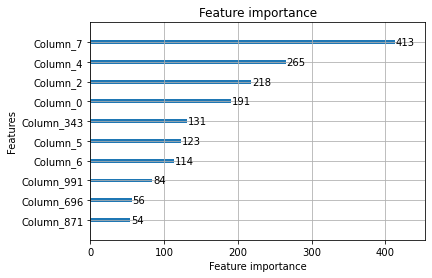

In [40]:
#let's plot the important features
lgb.plot_importance(model_lightgbm, max_num_features=10)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

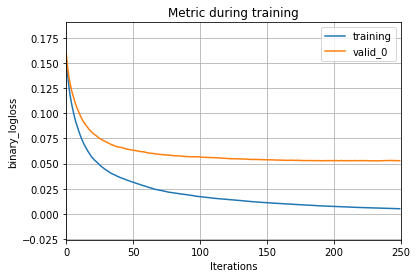

In [41]:
lgb.plot_metric(model_lightgbm)

In [42]:
print(metrics.classification_report(y_test,model_lightgbm.predict(x_test_scaled)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.94      0.71      0.81       173

    accuracy                           0.98      3576
   macro avg       0.96      0.85      0.90      3576
weighted avg       0.98      0.98      0.98      3576



In [43]:
print(metrics.classification_report(y_train,model_lightgbm.predict(x_train_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13611
           1       1.00      0.99      1.00       693

    accuracy                           1.00     14304
   macro avg       1.00      1.00      1.00     14304
weighted avg       1.00      1.00      1.00     14304



C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


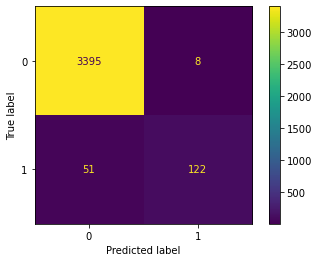

In [44]:
metrics.plot_confusion_matrix(model_lightgbm,x_test_scaled,y_test)

<AxesSubplot:>

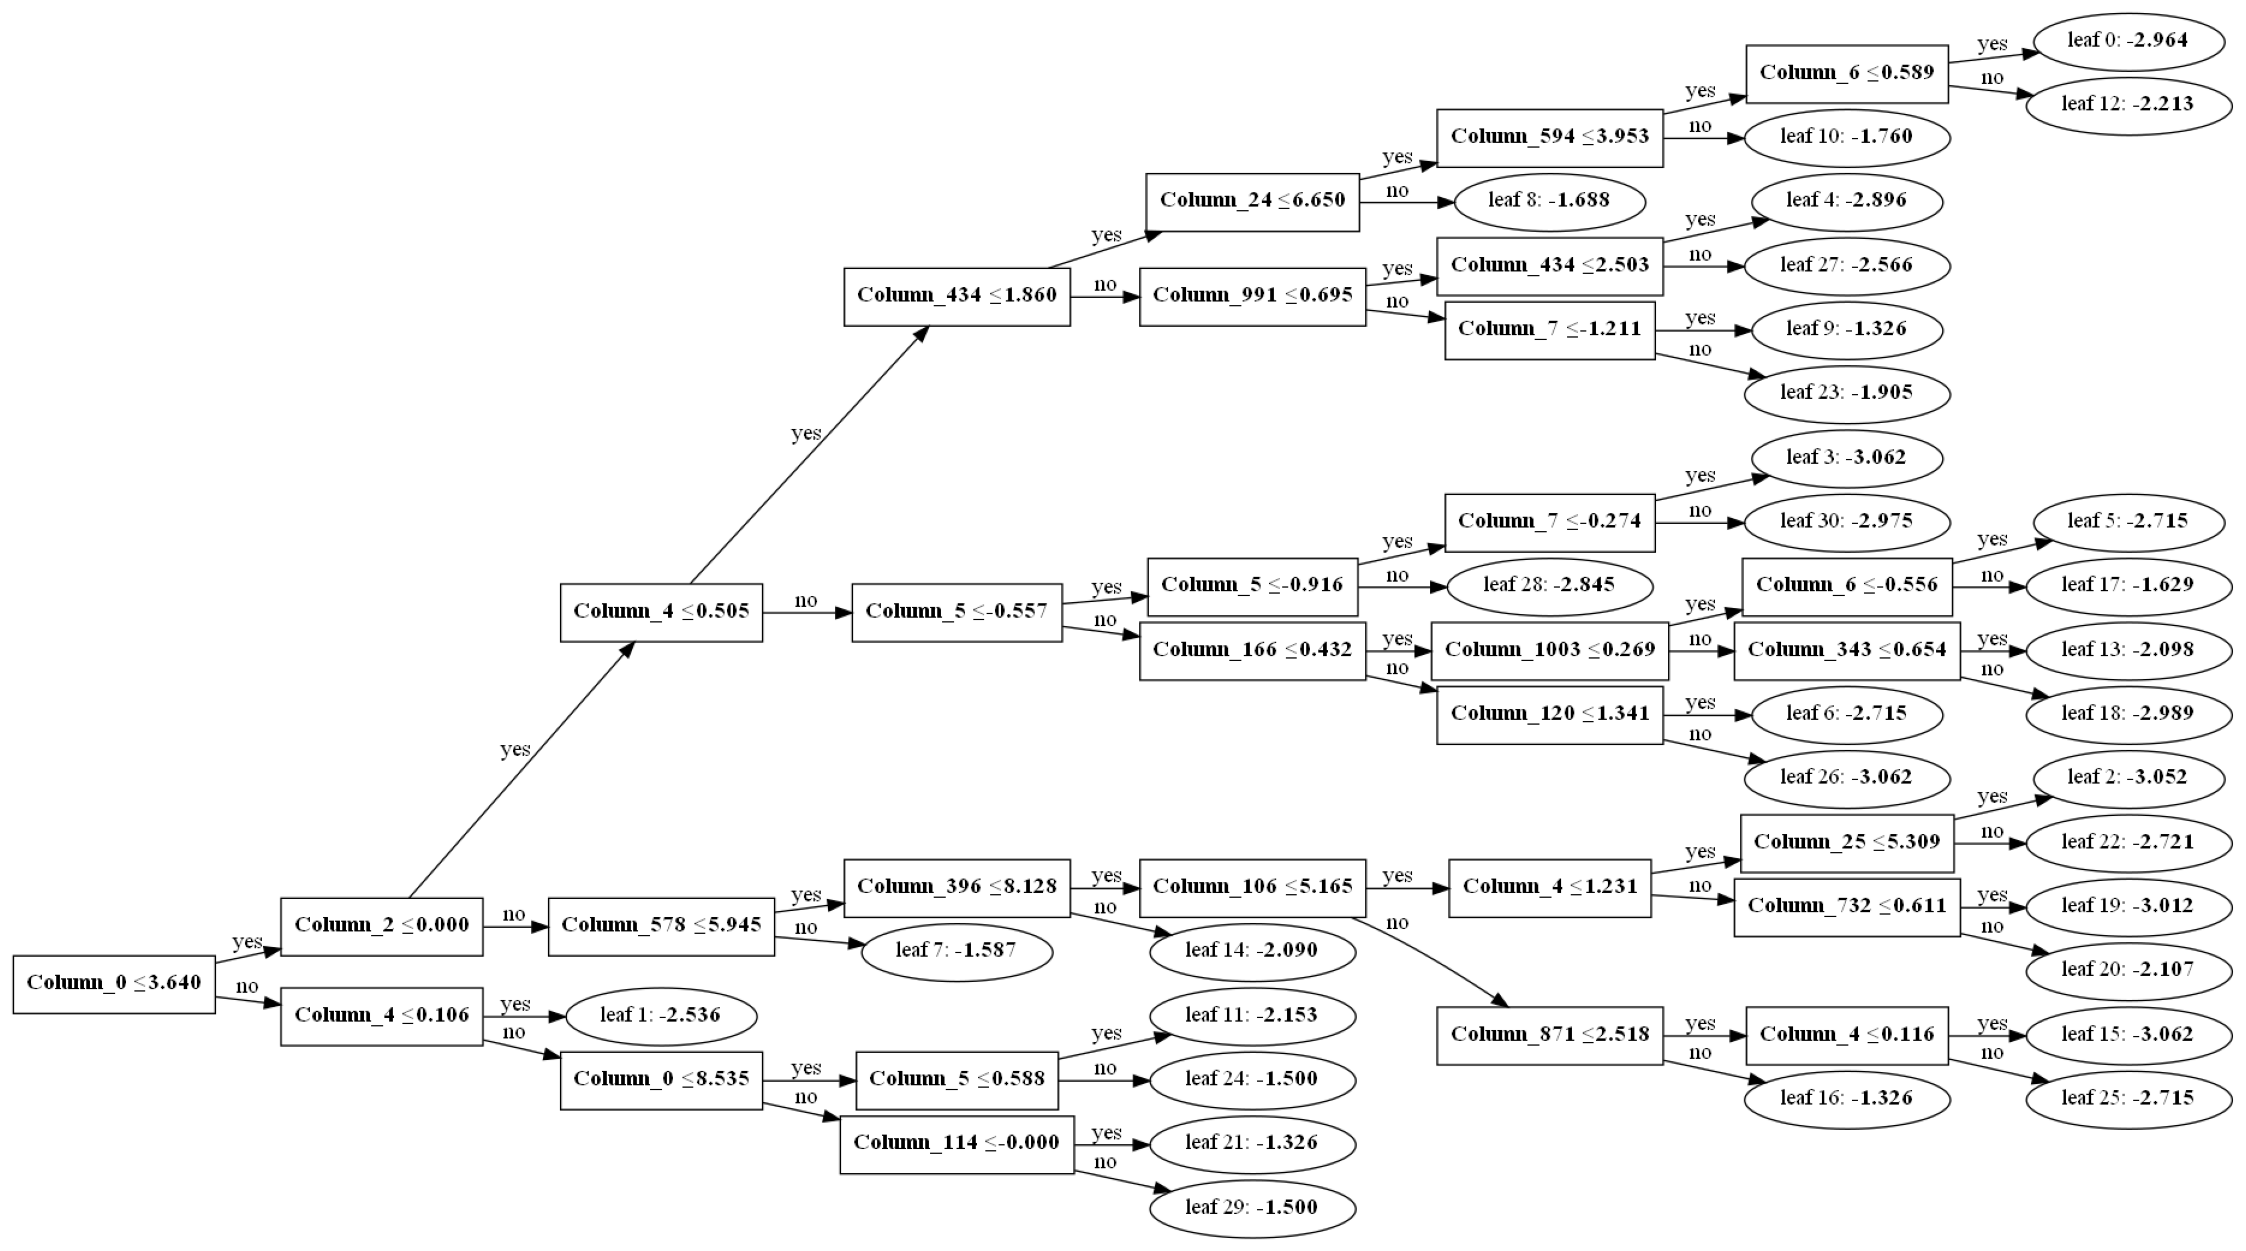

In [45]:
lgb.plot_tree(model_lightgbm,figsize=(40,50))

In [46]:
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer

In [47]:
model_xgboost = xgb.XGBClassifier(objective='binary:logistic', missing=1, seed= 42, random_state=1)
model_xgboost.fit(x_train_scaled,y_train,eval_set=[(x_test_scaled,y_test),(x_train_scaled,y_train)],
          verbose=50,eval_metric='aucpr')

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.62489	validation_1-aucpr:0.68810
[50]	validation_0-aucpr:0.88868	validation_1-aucpr:0.99822
[99]	validation_0-aucpr:0.89915	validation_1-aucpr:0.99987


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=1, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

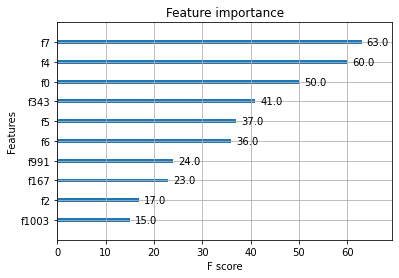

In [48]:
#let's plot the important features
xgb.plot_importance(model_xgboost, max_num_features=10)

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


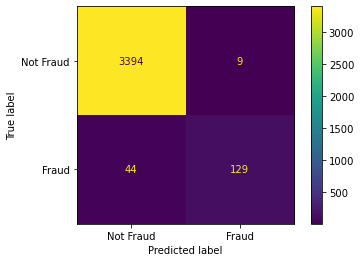

In [49]:
plot_confusion_matrix(model_xgboost, 
                      x_test_scaled, 
                      y_test, 
                      values_format='d',
                      display_labels=['Not Fraud','Fraud'])

In [50]:
print(metrics.classification_report(y_test,model_xgboost.predict(x_test_scaled)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.93      0.75      0.83       173

    accuracy                           0.99      3576
   macro avg       0.96      0.87      0.91      3576
weighted avg       0.98      0.99      0.98      3576



In [52]:
print(metrics.classification_report(y_train,model_lightgbm.predict(x_train_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13611
           1       1.00      0.99      1.00       693

    accuracy                           1.00     14304
   macro avg       1.00      1.00      1.00     14304
weighted avg       1.00      1.00      1.00     14304



In [53]:
# boosting

from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
   classifier = GradientBoostingClassifier(n_estimators=20,
   learning_rate=learning_rate,
   max_features=1000,
   max_depth=3,
   random_state=1)
   classifier.fit(x_train_scaled, y_train)
   print("Learning rate: ", learning_rate)
   print("Accuracy score (training): {0:.3f}".format(
       classifier.score(
           x_train_scaled,
           y_train)))
   print("Accuracy score (validation): {0:.3f}".format(
       classifier.score(
           x_test_scaled,
           y_test)))

Learning rate:  0.05
Accuracy score (training): 0.961
Accuracy score (validation): 0.962
Learning rate:  0.1
Accuracy score (training): 0.970
Accuracy score (validation): 0.967
Learning rate:  0.25
Accuracy score (training): 0.982
Accuracy score (validation): 0.978
Learning rate:  0.5
Accuracy score (training): 0.985
Accuracy score (validation): 0.976
Learning rate:  0.75
Accuracy score (training): 0.952
Accuracy score (validation): 0.946
Learning rate:  1
Accuracy score (training): 0.970
Accuracy score (validation): 0.961


In [54]:
classifier = GradientBoostingClassifier(n_estimators=20,
   learning_rate=0.5, max_features=1000, max_depth=3, random_state=1)

classifier.fit(x_train_scaled, y_train)
predictions = classifier.predict(x_test_scaled)

In [55]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
   cm, index=["Actual 0", "Actual 1"],
   columns=["Predicted 0", "Predicted 1"]
)
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,3382,21
Actual 1,65,108


In [56]:
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3403
           1       0.84      0.62      0.72       173

    accuracy                           0.98      3576
   macro avg       0.91      0.81      0.85      3576
weighted avg       0.97      0.98      0.97      3576

